In [2]:
! pip install opendatasets

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/allandclive/chicken-disease-1/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lucifer88
Your Kaggle Key: ··········


100%|██████████| 266M/266M [00:04<00:00, 59.7MB/s]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf

In [5]:
df = pd.read_csv('/content/chicken-disease-1/train_data.csv')
df.head()

,images,label
0,salmo.1558.jpg,Salmonella
1,cocci.1866.jpg,Coccidiosis
2,cocci.171.jpg,Coccidiosis
3,salmo.1484.jpg,Salmonella
4,ncd.100.jpg,New Castle Disease


In [5]:
df.label.value_counts()

Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
Name: label, dtype: int64

In [6]:
labels = list(df.label.unique())
labels

['Salmonella', 'Coccidiosis', 'New Castle Disease', 'Healthy']

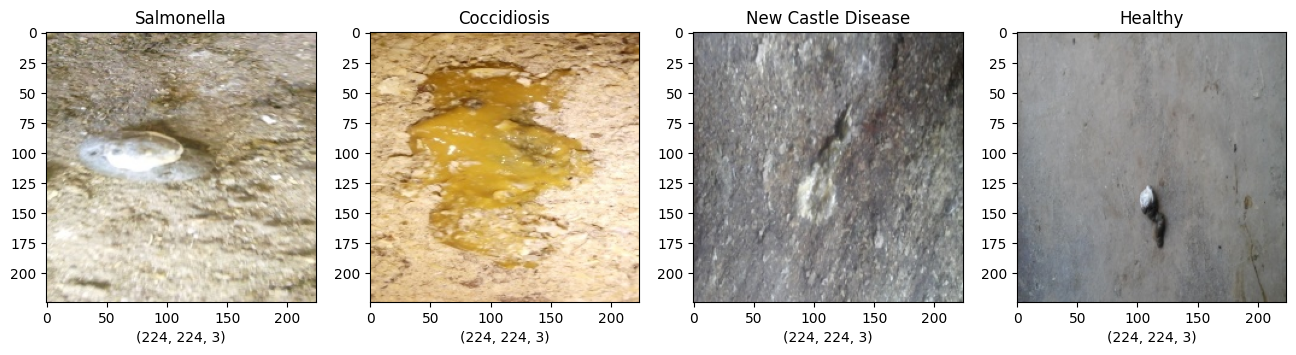

In [7]:
random_img = {}
for label in labels:
    id = np.random.choice(df[df['label']==label]['images'])
    random_img[id] = label

plt.subplots(1,4, figsize=(16,4))
i = 1
for img in random_img.keys():
    image = cv2.cvtColor(cv2.imread('/content/chicken-disease-1/Train/'+img), cv2.COLOR_BGR2RGB)
    plt.subplot(1,4,i)
    plt.imshow(image)
    plt.title(random_img[img])
    plt.xlabel(image.shape)
    i += 1

In [2]:
batch_size = 32
input_shape = (224,224,3)
target_size = (224,224)
preprocessor = tf.keras.applications.xception.preprocess_input

In [27]:
preprocessor = tf.keras.applications.xception.preprocess_input
path = '/content/drive/MyDrive'
filename = 'preprocessor.pkl'
# Create a full path to the file
full_path = os.path.join(path, filename)

# Open the file in binary write mode and dump the object
with open(full_path, 'wb') as f:
    pickle.dump(preprocessor, f)


In [21]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessor, validation_split=0.1)

In [3]:
xception = tf.keras.applications.xception.Xception(include_top=False, input_shape=input_shape)

In [25]:
train_idg = idg.flow_from_dataframe(dataframe=df,
                                    directory='/content/chicken-disease-1/Train/',
                                    x_col='images', y_col='label',
                                    batch_size=batch_size,
                                    target_size=target_size,
                                    subset='training')

Found 7261 validated image filenames belonging to 4 classes.


In [26]:
val_idg = idg.flow_from_dataframe(dataframe=df,
                                    directory='/content/chicken-disease-1/Train/',
                                    x_col='images', y_col='label',
                                    batch_size=batch_size,
                                    target_size=target_size,
                                    subset='validation')

Found 806 validated image filenames belonging to 4 classes.


In [4]:
xception.trainable = False

In [5]:
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [7]:
Xception = tf.keras.models.Model(inputs=[xception.input],
                                outputs=[xception.get_layer('block14_sepconv2_act').output])
Xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_sepconv2 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv2_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv2[0][0]']     
 ormalizat

In [8]:
flat = tf.keras.layers.Flatten()(Xception.output)
dense1 = tf.keras.layers.Dense(128, activation='relu')(flat)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
output = tf.keras.layers.Dense(4, activation='softmax')(dense2)

In [9]:
dl_model = tf.keras.models.Model(inputs=[Xception.input], outputs=output)

In [10]:
dl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

                                                                                                  
 block10_sepconv2_act (Acti  (None, 14, 14, 728)          0         ['block10_sepconv1_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block10_sepconv2 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv2_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block10_sepconv2_bn (Batch  (None, 14, 14, 728)          2912      ['block10_sepconv2[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 block10_s

In [19]:
dl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [20]:
dl_model.fit(train_idg, batch_size=batch_size, validation_data=val_idg, epochs=10)

Epoch 1/10
227/227 [==============================] - 48s 155ms/step - loss: 0.4281 - acc: 0.8508 - val_loss: 0.3135 - val_acc: 0.8945
Epoch 2/10
227/227 [==============================] - 34s 148ms/step - loss: 0.1934 - acc: 0.9431 - val_loss: 0.2750 - val_acc: 0.9132
Epoch 3/10
227/227 [==============================] - 34s 151ms/step - loss: 0.1291 - acc: 0.9674 - val_loss: 0.2569 - val_acc: 0.9144
Epoch 4/10
227/227 [==============================] - 35s 154ms/step - loss: 0.0893 - acc: 0.9803 - val_loss: 0.2555 - val_acc: 0.9144
Epoch 5/10
227/227 [==============================] - 37s 164ms/step - loss: 0.0662 - acc: 0.9873 - val_loss: 0.2415 - val_acc: 0.9194
Epoch 6/10
227/227 [==============================] - 38s 165ms/step - loss: 0.0504 - acc: 0.9906 - val_loss: 0.2622 - val_acc: 0.9156
Epoch 7/10
227/227 [==============================] - 36s 159ms/step - loss: 0.0417 - acc: 0.9931 - val_loss: 0.2552 - val_acc: 0.9194
Epoch 8/10
227/227 [==============================] - 3

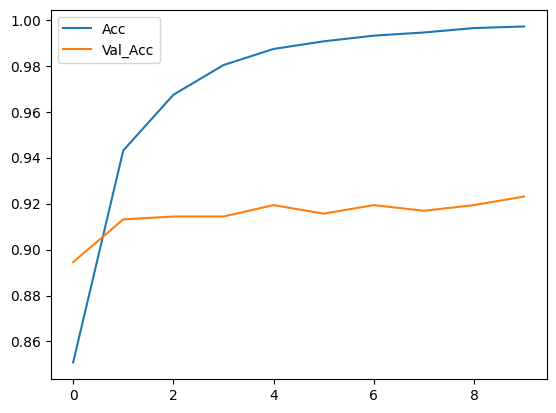

In [21]:
plt.plot(dl_model.history.history['acc'], label='Acc')
plt.plot(dl_model.history.history['val_acc'], label='Val_Acc')
plt.legend()

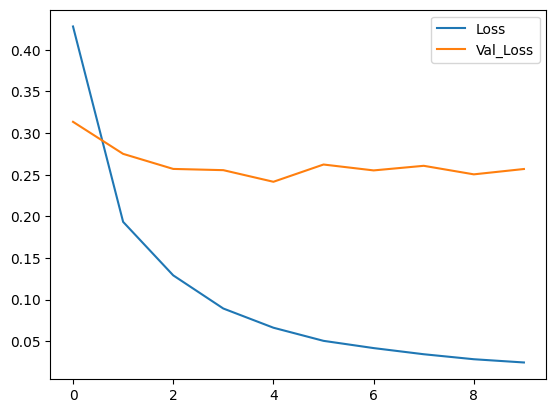

In [22]:
plt.plot(dl_model.history.history['loss'], label='Loss')
plt.plot(dl_model.history.history['val_loss'], label='Val_Loss')
plt.legend()

In [23]:
import pickle

In [24]:
path = '/content/drive/MyDrive'
filename = 'dlmodel.pkl'

In [26]:
path = '/content/drive/MyDrive'
filename = 'dl_model.pkl'
# Create a full path to the file
full_path = os.path.join(path, filename)

# Open the file in binary write mode and dump the object
with open(full_path, 'wb') as f:
    pickle.dump(dl_model, f)


In [1]:
import pickle
model = pickle.load(open('/content/drive/MyDrive/dl_model.pkl','rb'))
preprocessor = pickle.load(open('/content/drive/MyDrive/preprocessor.pkl','rb'))

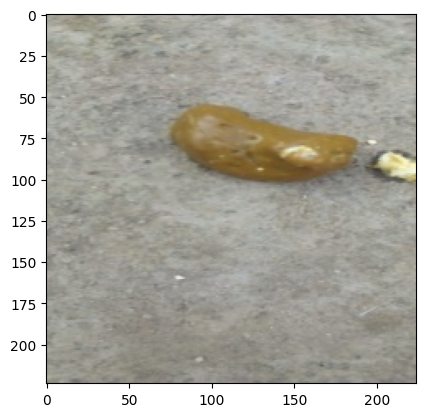

In [48]:
import cv2
x = np.random.randint(1,8000)
image = cv2.cvtColor(cv2.imread('/content/chicken-disease-1/Train/'+ df['images'][x]), cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [49]:
image = tf.keras.preprocessing.image.img_to_array(image)

<ipython-input-50-e879e7830dad>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(image.astype(np.int))


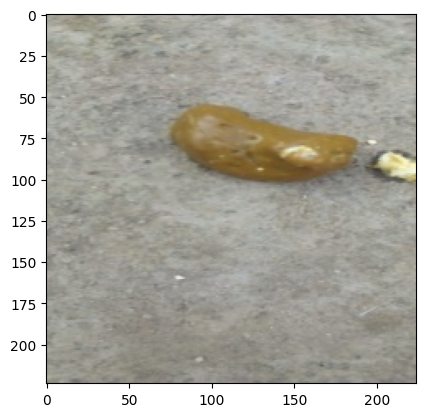

In [50]:
image = cv2.resize(image, (224, 224))
plt.imshow(image.astype(np.int))

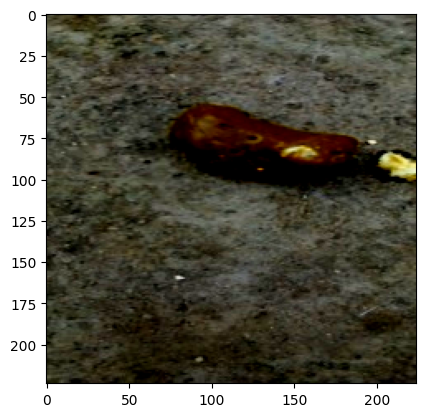

In [51]:
image_pre = preprocessor(image)
plt.imshow(image_pre)

In [52]:
image_pre = np.expand_dims(image_pre, axis=0)

In [53]:
image_pre.shape

(1, 224, 224, 3)

In [54]:
pred = model.predict(image_pre)

1/1 [==============================] - 0s 201ms/step


In [55]:
np.argmax(pred)

0

In [56]:
df['label'][x]

'Coccidiosis'

In [34]:
train_idg.class_indices

{'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}

In [11]:
dl_model.load_weights('weights.h5')

In [12]:
import pickle

In [13]:
preprocessor = pickle.load(open('preprocessor.pkl','rb'))

In [14]:
image = cv2.cvtColor(cv2.imread('da3d944e5ec4476161803fbd31b2f337.jpg'), cv2.COLOR_BGR2RGB)
image = tf.keras.preprocessing.image.img_to_array(image)
image = cv2.resize(image, (224, 224))
image_pre = preprocessor(image)
image_pre = np.expand_dims(image_pre, axis=0)

In [15]:
pred = dl_model.predict(image_pre)

1/1 [==============================] - 4s 4s/step


In [16]:
np.argmax(pred)

1

In [18]:
pickle.dump(dl_model,open('chicken.pkl','wb'))

In [19]:
model = pickle.load(open('chicken.pkl','rb'))

In [20]:
prediction = model.predict(image_pre)

1/1 [==============================] - 6s 6s/step


In [21]:
np.argmax(prediction)

1

In [22]:
prediction

array([[2.5942127e-04, 9.9529982e-01, 8.8913244e-04, 3.5516438e-03]],
      dtype=float32)